In [8]:
import time as t
import os

import matplotlib.image as image
import matplotlib.pyplot as plt
import numpy as np

import sklearn.metrics as sk_metrics
import sklearn.model_selection as sk_ms

from skimage.transform import resize

from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

1) Importing and downsizing images to 100x100 px

In [9]:
def import_directory(resolution, path: str):
    dirlist = os.listdir(path)
    images_array = np.empty((len(dirlist), resolution, resolution, 3), dtype=float)
    for i, im_name in enumerate(dirlist):
        print(i, f'. {path}')
        img = image.imread(f'{path}/{im_name}')
        images_array[i] = resize(img, (resolution, resolution), anti_aliasing=True)
    return images_array

2) Save images and categories to .npy files

In [10]:
def save_images(resolution):
    green_images = import_directory(resolution, './pictures/learning/green')
    ripe_images = import_directory(resolution, './pictures/learning/ripe')
    overripe_images = import_directory(resolution, './pictures/learning/overripe')
    test_samples_img = import_directory(resolution, './pictures/testing')

    images = np.concatenate((green_images, ripe_images, overripe_images))

    cat_green = np.full(len(green_images), 'green')
    cat_ripe = np.full(len(ripe_images), 'ripe')
    cat_overripe = np.full(len(overripe_images), 'overripe')
    categories = np.concatenate((cat_green, cat_ripe, cat_overripe))

    np.save('data/categories', categories)
    np.save('data/images', images)
    np.save('data/test_samples_img', test_samples_img)
    return [categories, images, test_samples_img]

3) Custom classifier class that takes single or multiple sklearn classifiers as arguments

In [11]:
class BananaClassifier:
    def __init__(self, *classifier):
        """Constructor initializes classifier object."""
        self.classifier = classifier
        self.learning_time = 0.0  # there should be a better way
        self.predicting_time = 0.0
        self.images = np.array([])
        self.categories = np.array([])
        self.resolution = np.array([])
        self.reshaped_images = np.array([])
        self.predictions = np.array([])
        self.reshaped_test_samples = np.array([])
        self.test_samples = np.array([])
        self.y_true = np.array(['overripe', 'ripe', 'green', 'green', 'green',
                                'overripe', 'green', 'overripe', 'overripe', 'ripe',
                                'ripe', 'ripe', 'ripe', 'overripe', 'green'])  # change to auto
        self.y_pred = np.array([])
        return

    def fit(self, images: np.ndarray, categories: np.ndarray, resolution: int):
        """Learn classifier to classify bananas based on photos."""
        self.images = images
        self.categories = categories
        self.resolution = resolution
        self.reshaped_images = self.images.reshape(len(self.images), 3 * self.resolution ** 2)

        start_time = t.time()

        for clf in self.classifier:
            clf.fit(self.reshaped_images, self.categories)

        end_time = t.time()
        self.learning_time = end_time - start_time
        return

    def predict(self, test_samples: np.ndarray, resolution: int):
        """Predict if banana is green, ripe or overripe."""
        self.test_samples = test_samples
        self.reshaped_test_samples = test_samples.reshape(len(test_samples), 3 * resolution ** 2)
        for i, _ in enumerate(self.reshaped_test_samples):
            all_probas = [None] * len(self.classifier)

            start_time = t.time()

            for y, _ in enumerate(self.classifier):
                all_probas[y] = self.classifier[y].predict_proba(self.reshaped_test_samples[i].reshape(1, -1))

            end_time = t.time()
            self.predicting_time = end_time - start_time

            avg = (sum(all_probas) / len(all_probas))[0]  # getting array out of array
            if avg[0] == max(avg):
                self.predictions = np.append(self.predictions, 'green')
            elif avg[1] == max(avg):
                self.predictions = np.append(self.predictions, 'overripe')
            else:
                self.predictions = np.append(self.predictions, 'ripe')
        return self.predictions

    def plot(self, title=""):
        """Display categorized photos of the bananas."""
        n_rows = 3
        n_cols = 5
        _, axes = plt.subplots(n_rows, n_cols)
        for i in range(n_rows):
            for j in range(n_cols):
                samples_index = i * n_cols + j
                axes[i][j].imshow(self.test_samples[samples_index])
                axes[i][j].axis('off')
                axes[i][j].set_title(self.predictions[samples_index])
        if title:
            plt.suptitle(title)
        else:
            classifiers_str = ""
            for obj in self.classifier:
                if classifiers_str:
                    classifiers_str = f"{classifiers_str}, {obj.__str__()}"
                else:
                    classifiers_str = obj.__str__()
            plt.suptitle(
                         f"{classifiers_str}\n "
#                          f"Learning time: {round(self.learning_time, 3)} [s]\n"
#                          f"Predicting time: {round(1000 * self.predicting_time, 3)} [ms]"
                        )
        plt.show()
        return

    def predict_and_plot(self, test_samples: np.ndarray, resolution: int, title=""):
        """Run predict and plot functions one after another."""
        predictions = self.predict(test_samples, resolution)
        self.plot(title)
        return predictions

    def print_metrics(self):
        """Print metrics of a custom classifier."""
        self.y_pred = self.predictions
        print(f"Accuracy: {round(sk_metrics.accuracy_score(self.y_true, self.y_pred), 3)}")
        print(f"F1 score: {round(sk_metrics.f1_score(self.y_true, self.y_pred, average='weighted'), 3)}")
        print(f"Precision: {round(sk_metrics.precision_score(self.y_true, self.y_pred, average='weighted'), 3)}")  # micro/macro/weighted
        print(f"Recall: {round(sk_metrics.recall_score(self.y_true, self.y_pred, average='weighted'), 3)}")
        print(f"Confusion matrix:\n{sk_metrics.confusion_matrix(self.y_true, self.y_pred)}")
        return

    def learning_curve(self, images: np.ndarray, categories: np.ndarray, resolution: int, n_points: int):
        """Plot learning curve of custom classifier."""
        reshaped_images = self.images.reshape(len(images), 3 * resolution ** 2)
        train_sizes, train_scores, test_scores = {}, {}, {}
        for clf in self.classifier:
            train_sizes[clf], train_scores[clf], test_scores[clf] = sk_ms.learning_curve(
                clf,
                reshaped_images,
                categories,
                train_sizes=np.linspace(0.1, 1.0, n_points)
            )
        avg_train_sizes = sum(train_sizes.values()) / len(train_sizes)
        avg_train_scores = sum(train_scores.values()) / len(train_scores)
        avg_test_scores = sum(test_scores.values()) / len(test_scores)

        a_train_s_array = np.empty(len(avg_train_scores), dtype=float)
        for i, a_train_s in enumerate(avg_train_scores):
            a_train_s_array[i] = sum(a_train_s) / len(a_train_s)

        plt.figure()
        plt.plot(avg_train_sizes, a_train_s_array)
        plt.xlabel('Iteration')
        plt.ylabel('Score')
        plt.show()

4) Using created class and functions to predict 

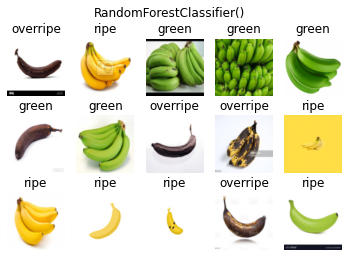

Accuracy: 0.867
F1 score: 0.866
Precision: 0.878
Recall: 0.867
Confusion matrix:
[[4 0 1]
 [1 4 0]
 [0 0 5]]


In [ ]:
resolution = 100

# save_images(resolution)  # comment out if new pictures have been added

categories = np.load('data/categories.npy')
images = np.load('data/images.npy')
test_samples = np.load('data/test_samples_img.npy')

classifier1 = BananaClassifier(RandomForestClassifier())
classifier1.fit(images, categories, resolution)
classifier1.predict_and_plot(test_samples, resolution)
classifier1.print_metrics()
classifier1.learning_curve(images, categories, resolution, n_points=8)